# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

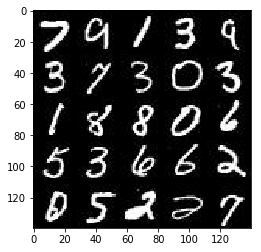

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

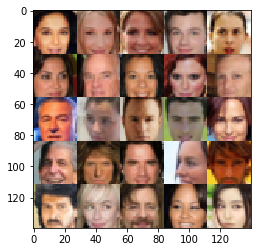

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # I will experiment with different values... if I don't run out of time @floydub
        alpha = 0.05
        kp = 0.9
        #image_size is 28x28xL[dataset] where L={'mnist': 1,'celeba': 3}
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05) )
        x1 = tf.maximum(alpha*x1, x1)
        
        #now 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same',  kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05) )
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=kp)
        
        #now 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 1, padding = 'same',  kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05))
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=kp)
        
        #now 7x7x256
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.05
        # input z noise... start with a dense layer of choice...reshape it... normalize it... leaky relu it
        x1 = tf.layers.dense(z, 7*7*256) #also try starting from 7*7*7*256...
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # now 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        #now 14x14x256
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',  kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        #now 28x28x128
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',  kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05))
        #I add just an other convolutional layer for redundancy of generator and smooth outputs
        logits = tf.layers.conv2d(x4, out_channel_dim, 5, strides = 1, padding='same',  kernel_initializer = tf.truncated_normal_initializer(stddev = 0.05))
        
        #now 28x28xL
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, _ = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # from [-0.5,0.5] to [-1,1]
                batch_images = 2*batch_images
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # I will run and opt generator more than once...
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})  
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                
                if (step%10==0) and (data_shape[3]==1):
                    print("Epoch: {}/{}   ".format(epoch_i+1, epoch_count), "Batch:   ".format(step), "D_Loss: {:.4f}   ".format(train_loss_d),"G_Loss: {:.4f}".format(train_loss_g))                
                if (step%100==0) and (data_shape[3]==1):
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)  
                if (step%100==0) and (data_shape[3]==3):
                    print("Epoch: {}/{}  ".format(epoch_i+1, epoch_count), "Batch:   ".format(step), "D_Loss: {:.4f}   ".format(train_loss_d),"G_Loss: {:.4f}".format(train_loss_g))                
                if (step%1000==0) and (data_shape[3]==3):
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)  
                    
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2    Batch:    D_Loss: 3.5894    G_Loss: 0.1708
Epoch: 1/2    Batch:    D_Loss: 3.6601    G_Loss: 0.0967
Epoch: 1/2    Batch:    D_Loss: 3.8558    G_Loss: 0.0467
Epoch: 1/2    Batch:    D_Loss: 3.1955    G_Loss: 0.0882
Epoch: 1/2    Batch:    D_Loss: 3.3927    G_Loss: 0.0558
Epoch: 1/2    Batch:    D_Loss: 3.0040    G_Loss: 0.1419
Epoch: 1/2    Batch:    D_Loss: 2.8528    G_Loss: 0.8651
Epoch: 1/2    Batch:    D_Loss: 2.2313    G_Loss: 0.6569
Epoch: 1/2    Batch:    D_Loss: 2.2956    G_Loss: 0.5581
Epoch: 1/2    Batch:    D_Loss: 2.5592    G_Loss: 0.1199


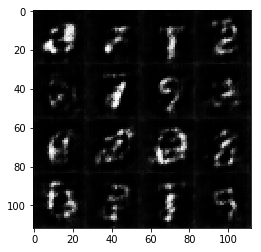

Epoch: 1/2    Batch:    D_Loss: 2.2321    G_Loss: 0.5782
Epoch: 1/2    Batch:    D_Loss: 2.3475    G_Loss: 0.1945
Epoch: 1/2    Batch:    D_Loss: 2.3652    G_Loss: 0.4328
Epoch: 1/2    Batch:    D_Loss: 2.0535    G_Loss: 0.4327
Epoch: 1/2    Batch:    D_Loss: 2.0282    G_Loss: 0.3663
Epoch: 1/2    Batch:    D_Loss: 1.8667    G_Loss: 0.4918
Epoch: 1/2    Batch:    D_Loss: 2.0538    G_Loss: 0.3334
Epoch: 1/2    Batch:    D_Loss: 2.3135    G_Loss: 0.1823
Epoch: 1/2    Batch:    D_Loss: 2.0668    G_Loss: 0.2056
Epoch: 1/2    Batch:    D_Loss: 2.3359    G_Loss: 0.1877


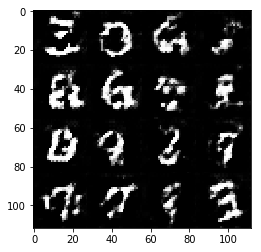

Epoch: 1/2    Batch:    D_Loss: 1.9721    G_Loss: 0.3054
Epoch: 1/2    Batch:    D_Loss: 2.3630    G_Loss: 0.1837
Epoch: 1/2    Batch:    D_Loss: 2.0924    G_Loss: 1.1690
Epoch: 1/2    Batch:    D_Loss: 2.5433    G_Loss: 0.1808
Epoch: 1/2    Batch:    D_Loss: 2.2549    G_Loss: 0.2078
Epoch: 1/2    Batch:    D_Loss: 2.4152    G_Loss: 0.1649
Epoch: 1/2    Batch:    D_Loss: 1.7718    G_Loss: 1.2304
Epoch: 1/2    Batch:    D_Loss: 2.0106    G_Loss: 0.2752
Epoch: 1/2    Batch:    D_Loss: 1.9932    G_Loss: 0.3989
Epoch: 1/2    Batch:    D_Loss: 2.0059    G_Loss: 0.3028


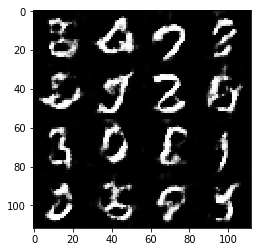

Epoch: 1/2    Batch:    D_Loss: 1.8568    G_Loss: 0.4434
Epoch: 1/2    Batch:    D_Loss: 1.9352    G_Loss: 0.3079
Epoch: 1/2    Batch:    D_Loss: 1.8979    G_Loss: 0.5674
Epoch: 1/2    Batch:    D_Loss: 2.0745    G_Loss: 0.2591
Epoch: 1/2    Batch:    D_Loss: 1.8256    G_Loss: 0.6513
Epoch: 1/2    Batch:    D_Loss: 2.0190    G_Loss: 0.3029
Epoch: 1/2    Batch:    D_Loss: 1.7834    G_Loss: 0.4441
Epoch: 1/2    Batch:    D_Loss: 1.7471    G_Loss: 1.0272
Epoch: 1/2    Batch:    D_Loss: 1.8245    G_Loss: 0.3756
Epoch: 1/2    Batch:    D_Loss: 2.6473    G_Loss: 0.1530


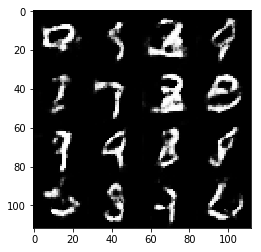

Epoch: 1/2    Batch:    D_Loss: 2.1088    G_Loss: 0.2254
Epoch: 1/2    Batch:    D_Loss: 2.1933    G_Loss: 0.2085
Epoch: 1/2    Batch:    D_Loss: 1.8483    G_Loss: 0.3963
Epoch: 1/2    Batch:    D_Loss: 2.0713    G_Loss: 0.4113
Epoch: 1/2    Batch:    D_Loss: 2.3357    G_Loss: 0.1913
Epoch: 1/2    Batch:    D_Loss: 1.7510    G_Loss: 0.4442
Epoch: 1/2    Batch:    D_Loss: 1.9283    G_Loss: 0.3776
Epoch: 1/2    Batch:    D_Loss: 2.1720    G_Loss: 0.2254
Epoch: 1/2    Batch:    D_Loss: 2.0346    G_Loss: 0.2989
Epoch: 1/2    Batch:    D_Loss: 1.7683    G_Loss: 0.6390


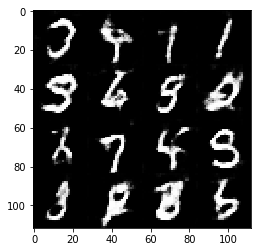

Epoch: 1/2    Batch:    D_Loss: 1.6733    G_Loss: 0.7509
Epoch: 1/2    Batch:    D_Loss: 2.0729    G_Loss: 0.2963
Epoch: 1/2    Batch:    D_Loss: 2.1475    G_Loss: 0.2890
Epoch: 1/2    Batch:    D_Loss: 1.7456    G_Loss: 0.9621
Epoch: 1/2    Batch:    D_Loss: 1.7952    G_Loss: 0.3334
Epoch: 1/2    Batch:    D_Loss: 1.7632    G_Loss: 0.9533
Epoch: 1/2    Batch:    D_Loss: 1.6860    G_Loss: 0.8292
Epoch: 1/2    Batch:    D_Loss: 1.7397    G_Loss: 0.5328
Epoch: 1/2    Batch:    D_Loss: 1.6901    G_Loss: 0.4439
Epoch: 1/2    Batch:    D_Loss: 1.9588    G_Loss: 1.1948


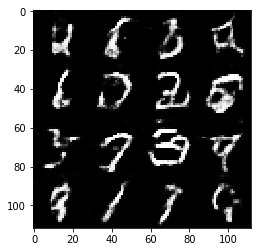

Epoch: 1/2    Batch:    D_Loss: 1.8212    G_Loss: 0.5049
Epoch: 1/2    Batch:    D_Loss: 1.5241    G_Loss: 0.6566
Epoch: 1/2    Batch:    D_Loss: 1.6706    G_Loss: 0.6041
Epoch: 1/2    Batch:    D_Loss: 1.7855    G_Loss: 0.4442
Epoch: 1/2    Batch:    D_Loss: 1.6975    G_Loss: 0.8589
Epoch: 1/2    Batch:    D_Loss: 1.5530    G_Loss: 1.1167
Epoch: 1/2    Batch:    D_Loss: 1.7683    G_Loss: 0.3162
Epoch: 1/2    Batch:    D_Loss: 1.9789    G_Loss: 1.0723
Epoch: 1/2    Batch:    D_Loss: 1.6276    G_Loss: 0.9706
Epoch: 1/2    Batch:    D_Loss: 1.8258    G_Loss: 0.4227


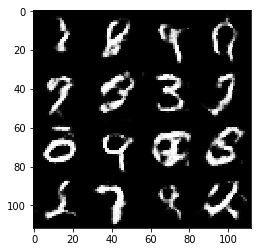

Epoch: 1/2    Batch:    D_Loss: 1.7661    G_Loss: 0.5162
Epoch: 1/2    Batch:    D_Loss: 1.7560    G_Loss: 0.3415
Epoch: 1/2    Batch:    D_Loss: 1.6702    G_Loss: 0.5190
Epoch: 1/2    Batch:    D_Loss: 1.7681    G_Loss: 0.7177
Epoch: 1/2    Batch:    D_Loss: 1.7991    G_Loss: 0.3931
Epoch: 1/2    Batch:    D_Loss: 1.8352    G_Loss: 0.3106
Epoch: 1/2    Batch:    D_Loss: 1.7835    G_Loss: 1.3108
Epoch: 1/2    Batch:    D_Loss: 1.9725    G_Loss: 0.3518
Epoch: 1/2    Batch:    D_Loss: 1.9907    G_Loss: 0.3214
Epoch: 1/2    Batch:    D_Loss: 2.3020    G_Loss: 1.5217


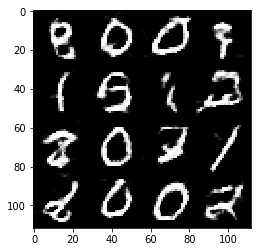

Epoch: 1/2    Batch:    D_Loss: 1.9423    G_Loss: 0.2825
Epoch: 1/2    Batch:    D_Loss: 1.7454    G_Loss: 0.3776
Epoch: 1/2    Batch:    D_Loss: 1.8125    G_Loss: 0.5125
Epoch: 1/2    Batch:    D_Loss: 1.6201    G_Loss: 0.5159
Epoch: 1/2    Batch:    D_Loss: 1.7824    G_Loss: 0.5290
Epoch: 1/2    Batch:    D_Loss: 1.7212    G_Loss: 0.4669
Epoch: 1/2    Batch:    D_Loss: 1.6556    G_Loss: 0.6110
Epoch: 1/2    Batch:    D_Loss: 1.7447    G_Loss: 0.4839
Epoch: 1/2    Batch:    D_Loss: 2.0414    G_Loss: 0.9495
Epoch: 1/2    Batch:    D_Loss: 2.0290    G_Loss: 0.2910


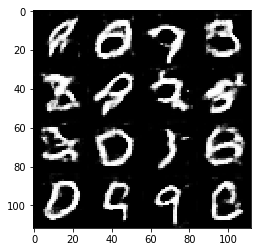

Epoch: 1/2    Batch:    D_Loss: 1.6062    G_Loss: 0.7769
Epoch: 1/2    Batch:    D_Loss: 2.0654    G_Loss: 0.2733
Epoch: 1/2    Batch:    D_Loss: 1.9000    G_Loss: 0.7295
Epoch: 1/2    Batch:    D_Loss: 2.0393    G_Loss: 1.5520
Epoch: 1/2    Batch:    D_Loss: 1.6944    G_Loss: 0.4624
Epoch: 1/2    Batch:    D_Loss: 1.8696    G_Loss: 0.4010
Epoch: 1/2    Batch:    D_Loss: 1.5782    G_Loss: 0.8097
Epoch: 1/2    Batch:    D_Loss: 1.6875    G_Loss: 0.6877
Epoch: 1/2    Batch:    D_Loss: 2.0171    G_Loss: 0.2628
Epoch: 1/2    Batch:    D_Loss: 1.8652    G_Loss: 0.3432


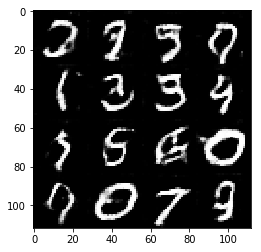

Epoch: 1/2    Batch:    D_Loss: 1.5285    G_Loss: 0.7082
Epoch: 1/2    Batch:    D_Loss: 1.7759    G_Loss: 0.3100
Epoch: 1/2    Batch:    D_Loss: 1.7957    G_Loss: 0.4086
Epoch: 1/2    Batch:    D_Loss: 2.5957    G_Loss: 0.1767
Epoch: 1/2    Batch:    D_Loss: 1.6879    G_Loss: 0.5127
Epoch: 1/2    Batch:    D_Loss: 1.7513    G_Loss: 0.4464
Epoch: 1/2    Batch:    D_Loss: 1.6767    G_Loss: 0.4803
Epoch: 1/2    Batch:    D_Loss: 2.0222    G_Loss: 0.2524
Epoch: 1/2    Batch:    D_Loss: 2.0056    G_Loss: 0.2573
Epoch: 1/2    Batch:    D_Loss: 2.2039    G_Loss: 0.2066


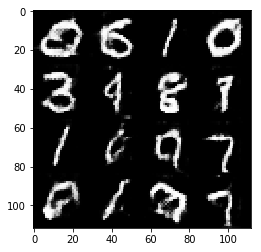

Epoch: 1/2    Batch:    D_Loss: 1.7761    G_Loss: 0.5174
Epoch: 1/2    Batch:    D_Loss: 1.7274    G_Loss: 0.5203
Epoch: 1/2    Batch:    D_Loss: 1.7231    G_Loss: 0.3781
Epoch: 1/2    Batch:    D_Loss: 1.7287    G_Loss: 0.3971
Epoch: 1/2    Batch:    D_Loss: 2.1521    G_Loss: 0.3006
Epoch: 1/2    Batch:    D_Loss: 1.9828    G_Loss: 0.2899
Epoch: 1/2    Batch:    D_Loss: 1.9340    G_Loss: 1.1760
Epoch: 1/2    Batch:    D_Loss: 1.8627    G_Loss: 0.3401
Epoch: 1/2    Batch:    D_Loss: 1.6609    G_Loss: 0.4332
Epoch: 1/2    Batch:    D_Loss: 2.1719    G_Loss: 0.1894


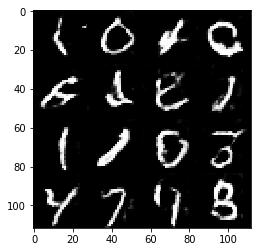

Epoch: 1/2    Batch:    D_Loss: 1.8616    G_Loss: 0.6721
Epoch: 1/2    Batch:    D_Loss: 1.4888    G_Loss: 0.6477
Epoch: 1/2    Batch:    D_Loss: 1.8415    G_Loss: 0.3317
Epoch: 1/2    Batch:    D_Loss: 2.0260    G_Loss: 0.2991
Epoch: 1/2    Batch:    D_Loss: 1.9532    G_Loss: 0.2932
Epoch: 1/2    Batch:    D_Loss: 1.7333    G_Loss: 0.3656
Epoch: 1/2    Batch:    D_Loss: 1.6168    G_Loss: 0.4408
Epoch: 1/2    Batch:    D_Loss: 1.5557    G_Loss: 0.5361
Epoch: 1/2    Batch:    D_Loss: 2.8907    G_Loss: 0.0849
Epoch: 1/2    Batch:    D_Loss: 2.2946    G_Loss: 0.2162


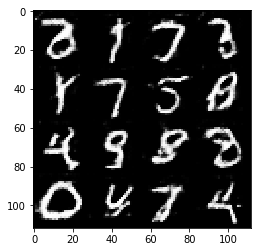

Epoch: 1/2    Batch:    D_Loss: 1.7040    G_Loss: 0.6492
Epoch: 1/2    Batch:    D_Loss: 1.6121    G_Loss: 0.6164
Epoch: 1/2    Batch:    D_Loss: 1.8191    G_Loss: 0.4114
Epoch: 1/2    Batch:    D_Loss: 1.5638    G_Loss: 0.7189
Epoch: 1/2    Batch:    D_Loss: 1.7552    G_Loss: 0.3902
Epoch: 1/2    Batch:    D_Loss: 1.7855    G_Loss: 0.3627
Epoch: 1/2    Batch:    D_Loss: 1.5509    G_Loss: 0.6776
Epoch: 1/2    Batch:    D_Loss: 1.6043    G_Loss: 0.4568
Epoch: 1/2    Batch:    D_Loss: 1.8048    G_Loss: 0.3226
Epoch: 1/2    Batch:    D_Loss: 1.6187    G_Loss: 0.7000


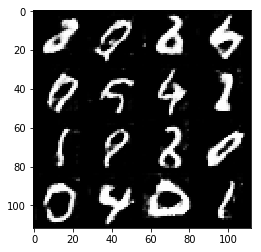

Epoch: 1/2    Batch:    D_Loss: 1.7609    G_Loss: 0.4403
Epoch: 1/2    Batch:    D_Loss: 1.6610    G_Loss: 0.4399
Epoch: 1/2    Batch:    D_Loss: 1.5924    G_Loss: 0.4492
Epoch: 1/2    Batch:    D_Loss: 2.2430    G_Loss: 0.2110
Epoch: 1/2    Batch:    D_Loss: 1.7367    G_Loss: 0.3208
Epoch: 1/2    Batch:    D_Loss: 1.6764    G_Loss: 1.0485
Epoch: 1/2    Batch:    D_Loss: 1.4281    G_Loss: 0.7802
Epoch: 1/2    Batch:    D_Loss: 2.0001    G_Loss: 0.3115
Epoch: 1/2    Batch:    D_Loss: 1.5609    G_Loss: 0.6020
Epoch: 1/2    Batch:    D_Loss: 1.5997    G_Loss: 0.8479


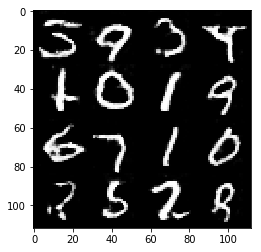

Epoch: 1/2    Batch:    D_Loss: 1.7274    G_Loss: 0.6167
Epoch: 1/2    Batch:    D_Loss: 1.5206    G_Loss: 0.5353
Epoch: 1/2    Batch:    D_Loss: 2.0993    G_Loss: 0.2426
Epoch: 1/2    Batch:    D_Loss: 1.5770    G_Loss: 0.5099
Epoch: 1/2    Batch:    D_Loss: 1.6264    G_Loss: 0.6401
Epoch: 1/2    Batch:    D_Loss: 1.4445    G_Loss: 0.6841
Epoch: 1/2    Batch:    D_Loss: 1.3748    G_Loss: 0.6488
Epoch: 1/2    Batch:    D_Loss: 1.8630    G_Loss: 0.2916
Epoch: 1/2    Batch:    D_Loss: 1.5477    G_Loss: 0.6809
Epoch: 1/2    Batch:    D_Loss: 2.0089    G_Loss: 0.4982


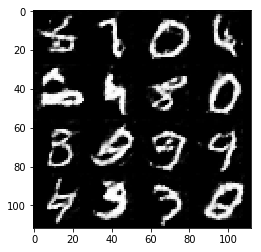

Epoch: 1/2    Batch:    D_Loss: 1.6294    G_Loss: 0.4651
Epoch: 1/2    Batch:    D_Loss: 1.9238    G_Loss: 0.3894
Epoch: 1/2    Batch:    D_Loss: 1.5981    G_Loss: 0.9299
Epoch: 1/2    Batch:    D_Loss: 1.6101    G_Loss: 0.5453
Epoch: 1/2    Batch:    D_Loss: 1.6936    G_Loss: 0.3844
Epoch: 1/2    Batch:    D_Loss: 1.6002    G_Loss: 0.6304
Epoch: 1/2    Batch:    D_Loss: 1.5095    G_Loss: 0.5701
Epoch: 1/2    Batch:    D_Loss: 1.6521    G_Loss: 0.6677
Epoch: 1/2    Batch:    D_Loss: 1.7174    G_Loss: 0.7771
Epoch: 1/2    Batch:    D_Loss: 1.6144    G_Loss: 0.4420


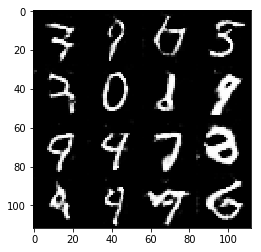

Epoch: 1/2    Batch:    D_Loss: 1.5070    G_Loss: 0.7043
Epoch: 1/2    Batch:    D_Loss: 1.7122    G_Loss: 0.3751
Epoch: 1/2    Batch:    D_Loss: 2.0546    G_Loss: 0.2831
Epoch: 1/2    Batch:    D_Loss: 1.5346    G_Loss: 0.6048
Epoch: 1/2    Batch:    D_Loss: 1.4889    G_Loss: 0.7538
Epoch: 1/2    Batch:    D_Loss: 1.5555    G_Loss: 0.6135
Epoch: 1/2    Batch:    D_Loss: 1.6346    G_Loss: 0.4385
Epoch: 1/2    Batch:    D_Loss: 1.6753    G_Loss: 0.7222
Epoch: 1/2    Batch:    D_Loss: 1.8022    G_Loss: 0.3640
Epoch: 1/2    Batch:    D_Loss: 1.7906    G_Loss: 0.4273


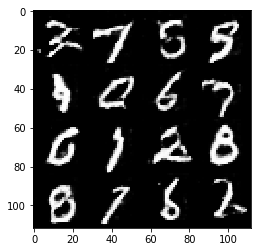

Epoch: 1/2    Batch:    D_Loss: 2.2488    G_Loss: 0.2386
Epoch: 1/2    Batch:    D_Loss: 1.4471    G_Loss: 0.5636
Epoch: 1/2    Batch:    D_Loss: 1.6369    G_Loss: 0.5890
Epoch: 1/2    Batch:    D_Loss: 1.3704    G_Loss: 0.8397
Epoch: 1/2    Batch:    D_Loss: 1.7484    G_Loss: 0.3658
Epoch: 1/2    Batch:    D_Loss: 1.3759    G_Loss: 0.8175
Epoch: 1/2    Batch:    D_Loss: 2.2490    G_Loss: 1.6175
Epoch: 2/2    Batch:    D_Loss: 1.6854    G_Loss: 0.4091
Epoch: 2/2    Batch:    D_Loss: 1.3925    G_Loss: 0.8756
Epoch: 2/2    Batch:    D_Loss: 1.5358    G_Loss: 0.4590


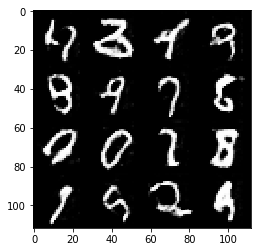

Epoch: 2/2    Batch:    D_Loss: 1.4941    G_Loss: 0.4807
Epoch: 2/2    Batch:    D_Loss: 1.7080    G_Loss: 0.4181
Epoch: 2/2    Batch:    D_Loss: 1.5504    G_Loss: 0.5125
Epoch: 2/2    Batch:    D_Loss: 1.3715    G_Loss: 0.8727
Epoch: 2/2    Batch:    D_Loss: 1.6626    G_Loss: 0.6729
Epoch: 2/2    Batch:    D_Loss: 1.6109    G_Loss: 0.4655
Epoch: 2/2    Batch:    D_Loss: 1.5384    G_Loss: 0.7940
Epoch: 2/2    Batch:    D_Loss: 1.4994    G_Loss: 0.9374
Epoch: 2/2    Batch:    D_Loss: 1.7632    G_Loss: 0.4073
Epoch: 2/2    Batch:    D_Loss: 1.4510    G_Loss: 1.0844


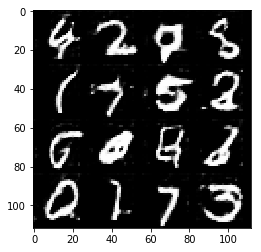

Epoch: 2/2    Batch:    D_Loss: 1.7272    G_Loss: 0.6389
Epoch: 2/2    Batch:    D_Loss: 1.3310    G_Loss: 0.7419
Epoch: 2/2    Batch:    D_Loss: 1.3227    G_Loss: 0.7835
Epoch: 2/2    Batch:    D_Loss: 1.4625    G_Loss: 1.3298
Epoch: 2/2    Batch:    D_Loss: 1.8112    G_Loss: 0.5286
Epoch: 2/2    Batch:    D_Loss: 1.5193    G_Loss: 0.4796
Epoch: 2/2    Batch:    D_Loss: 1.5400    G_Loss: 0.5514
Epoch: 2/2    Batch:    D_Loss: 1.8094    G_Loss: 0.5262
Epoch: 2/2    Batch:    D_Loss: 1.4532    G_Loss: 0.6528
Epoch: 2/2    Batch:    D_Loss: 1.5405    G_Loss: 0.3462


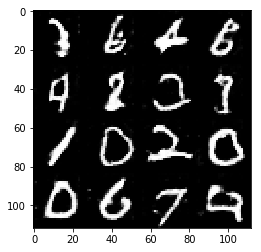

Epoch: 2/2    Batch:    D_Loss: 1.4224    G_Loss: 1.4861
Epoch: 2/2    Batch:    D_Loss: 1.9169    G_Loss: 0.3119
Epoch: 2/2    Batch:    D_Loss: 1.4151    G_Loss: 0.6117
Epoch: 2/2    Batch:    D_Loss: 1.3682    G_Loss: 0.6150
Epoch: 2/2    Batch:    D_Loss: 1.8081    G_Loss: 0.4440
Epoch: 2/2    Batch:    D_Loss: 1.4895    G_Loss: 0.7051
Epoch: 2/2    Batch:    D_Loss: 1.4516    G_Loss: 0.5484
Epoch: 2/2    Batch:    D_Loss: 1.7450    G_Loss: 0.3618
Epoch: 2/2    Batch:    D_Loss: 1.7185    G_Loss: 0.4339
Epoch: 2/2    Batch:    D_Loss: 1.8947    G_Loss: 0.3907


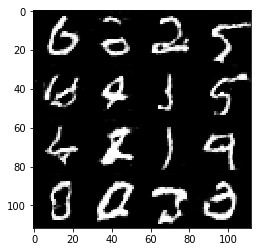

Epoch: 2/2    Batch:    D_Loss: 1.6044    G_Loss: 0.4962
Epoch: 2/2    Batch:    D_Loss: 1.7190    G_Loss: 0.5819
Epoch: 2/2    Batch:    D_Loss: 1.9142    G_Loss: 0.6279
Epoch: 2/2    Batch:    D_Loss: 1.7791    G_Loss: 0.3796
Epoch: 2/2    Batch:    D_Loss: 1.5417    G_Loss: 0.6566
Epoch: 2/2    Batch:    D_Loss: 1.5710    G_Loss: 1.0253
Epoch: 2/2    Batch:    D_Loss: 1.9305    G_Loss: 0.4093
Epoch: 2/2    Batch:    D_Loss: 2.3386    G_Loss: 0.2110
Epoch: 2/2    Batch:    D_Loss: 1.7602    G_Loss: 0.4875
Epoch: 2/2    Batch:    D_Loss: 1.8750    G_Loss: 0.2723


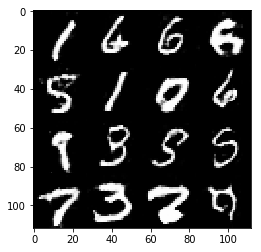

Epoch: 2/2    Batch:    D_Loss: 2.0397    G_Loss: 0.2326
Epoch: 2/2    Batch:    D_Loss: 1.8320    G_Loss: 0.3478
Epoch: 2/2    Batch:    D_Loss: 1.4840    G_Loss: 0.6311
Epoch: 2/2    Batch:    D_Loss: 1.8617    G_Loss: 0.3521
Epoch: 2/2    Batch:    D_Loss: 2.1484    G_Loss: 0.1974
Epoch: 2/2    Batch:    D_Loss: 1.5301    G_Loss: 0.7182
Epoch: 2/2    Batch:    D_Loss: 1.3684    G_Loss: 1.0810
Epoch: 2/2    Batch:    D_Loss: 2.0525    G_Loss: 0.2386
Epoch: 2/2    Batch:    D_Loss: 1.8939    G_Loss: 0.2897
Epoch: 2/2    Batch:    D_Loss: 2.1432    G_Loss: 0.2489


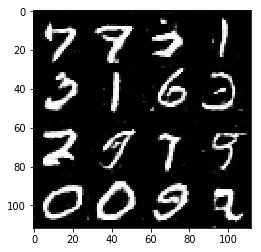

Epoch: 2/2    Batch:    D_Loss: 2.1413    G_Loss: 0.2437
Epoch: 2/2    Batch:    D_Loss: 1.9218    G_Loss: 0.2772
Epoch: 2/2    Batch:    D_Loss: 1.9522    G_Loss: 0.3166
Epoch: 2/2    Batch:    D_Loss: 1.8895    G_Loss: 0.3265
Epoch: 2/2    Batch:    D_Loss: 1.8233    G_Loss: 0.3746
Epoch: 2/2    Batch:    D_Loss: 2.2304    G_Loss: 0.2323
Epoch: 2/2    Batch:    D_Loss: 1.3276    G_Loss: 1.2774
Epoch: 2/2    Batch:    D_Loss: 1.6977    G_Loss: 0.3699
Epoch: 2/2    Batch:    D_Loss: 2.5742    G_Loss: 0.1571
Epoch: 2/2    Batch:    D_Loss: 1.6562    G_Loss: 0.4483


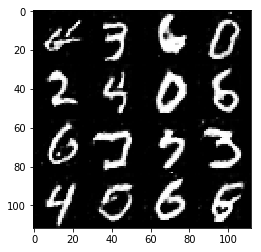

Epoch: 2/2    Batch:    D_Loss: 1.7540    G_Loss: 0.4253
Epoch: 2/2    Batch:    D_Loss: 1.4992    G_Loss: 0.7995
Epoch: 2/2    Batch:    D_Loss: 1.8570    G_Loss: 0.5532
Epoch: 2/2    Batch:    D_Loss: 2.0642    G_Loss: 0.3200
Epoch: 2/2    Batch:    D_Loss: 1.9111    G_Loss: 0.4743
Epoch: 2/2    Batch:    D_Loss: 1.4513    G_Loss: 0.7931
Epoch: 2/2    Batch:    D_Loss: 1.4538    G_Loss: 1.0866
Epoch: 2/2    Batch:    D_Loss: 1.9257    G_Loss: 0.2744
Epoch: 2/2    Batch:    D_Loss: 1.4741    G_Loss: 0.8945
Epoch: 2/2    Batch:    D_Loss: 1.8739    G_Loss: 0.3255


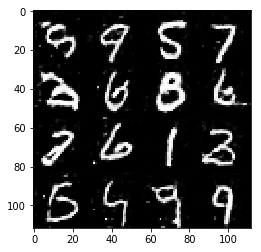

Epoch: 2/2    Batch:    D_Loss: 1.7144    G_Loss: 0.3714
Epoch: 2/2    Batch:    D_Loss: 1.7527    G_Loss: 0.6021
Epoch: 2/2    Batch:    D_Loss: 1.5500    G_Loss: 0.4894
Epoch: 2/2    Batch:    D_Loss: 1.4976    G_Loss: 0.6031
Epoch: 2/2    Batch:    D_Loss: 1.7151    G_Loss: 0.5935
Epoch: 2/2    Batch:    D_Loss: 1.6069    G_Loss: 0.5344
Epoch: 2/2    Batch:    D_Loss: 1.7790    G_Loss: 0.3150
Epoch: 2/2    Batch:    D_Loss: 1.5967    G_Loss: 0.9789
Epoch: 2/2    Batch:    D_Loss: 1.6202    G_Loss: 0.4813
Epoch: 2/2    Batch:    D_Loss: 1.2556    G_Loss: 0.8132


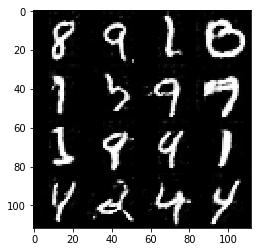

Epoch: 2/2    Batch:    D_Loss: 1.7075    G_Loss: 0.4800
Epoch: 2/2    Batch:    D_Loss: 1.8292    G_Loss: 0.3119
Epoch: 2/2    Batch:    D_Loss: 1.3958    G_Loss: 0.7396
Epoch: 2/2    Batch:    D_Loss: 1.4598    G_Loss: 0.7546
Epoch: 2/2    Batch:    D_Loss: 1.8061    G_Loss: 0.4000
Epoch: 2/2    Batch:    D_Loss: 1.5727    G_Loss: 0.9819
Epoch: 2/2    Batch:    D_Loss: 1.9108    G_Loss: 0.4195
Epoch: 2/2    Batch:    D_Loss: 1.4802    G_Loss: 0.9415
Epoch: 2/2    Batch:    D_Loss: 1.5344    G_Loss: 0.5536
Epoch: 2/2    Batch:    D_Loss: 2.1631    G_Loss: 1.2102


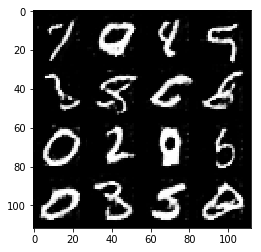

Epoch: 2/2    Batch:    D_Loss: 1.8833    G_Loss: 0.4936
Epoch: 2/2    Batch:    D_Loss: 1.1117    G_Loss: 0.9764
Epoch: 2/2    Batch:    D_Loss: 1.6315    G_Loss: 0.4581
Epoch: 2/2    Batch:    D_Loss: 1.6676    G_Loss: 0.4158
Epoch: 2/2    Batch:    D_Loss: 1.3342    G_Loss: 0.7284
Epoch: 2/2    Batch:    D_Loss: 2.7292    G_Loss: 0.1202
Epoch: 2/2    Batch:    D_Loss: 2.0542    G_Loss: 0.3050
Epoch: 2/2    Batch:    D_Loss: 1.6375    G_Loss: 0.4006
Epoch: 2/2    Batch:    D_Loss: 1.4330    G_Loss: 0.8355
Epoch: 2/2    Batch:    D_Loss: 1.5619    G_Loss: 0.4546


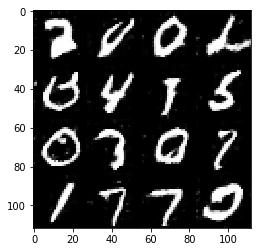

Epoch: 2/2    Batch:    D_Loss: 1.8363    G_Loss: 0.3407
Epoch: 2/2    Batch:    D_Loss: 1.6088    G_Loss: 0.5673
Epoch: 2/2    Batch:    D_Loss: 2.1089    G_Loss: 0.2569
Epoch: 2/2    Batch:    D_Loss: 1.7058    G_Loss: 0.5398
Epoch: 2/2    Batch:    D_Loss: 1.4633    G_Loss: 0.6265
Epoch: 2/2    Batch:    D_Loss: 1.8698    G_Loss: 0.2693
Epoch: 2/2    Batch:    D_Loss: 1.3558    G_Loss: 0.7353
Epoch: 2/2    Batch:    D_Loss: 1.9641    G_Loss: 0.2891
Epoch: 2/2    Batch:    D_Loss: 2.3724    G_Loss: 0.1796
Epoch: 2/2    Batch:    D_Loss: 1.3218    G_Loss: 1.1653


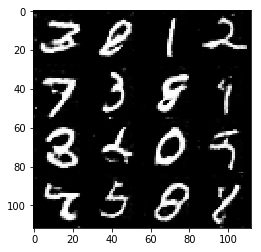

Epoch: 2/2    Batch:    D_Loss: 1.9121    G_Loss: 0.3778
Epoch: 2/2    Batch:    D_Loss: 1.6475    G_Loss: 0.5791
Epoch: 2/2    Batch:    D_Loss: 1.5942    G_Loss: 0.4871
Epoch: 2/2    Batch:    D_Loss: 2.0009    G_Loss: 0.3146
Epoch: 2/2    Batch:    D_Loss: 1.9335    G_Loss: 0.2824
Epoch: 2/2    Batch:    D_Loss: 1.6463    G_Loss: 0.3447
Epoch: 2/2    Batch:    D_Loss: 1.9580    G_Loss: 0.3224
Epoch: 2/2    Batch:    D_Loss: 1.3458    G_Loss: 0.7315
Epoch: 2/2    Batch:    D_Loss: 2.0917    G_Loss: 0.2889
Epoch: 2/2    Batch:    D_Loss: 1.5200    G_Loss: 1.6267


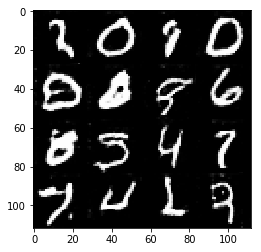

Epoch: 2/2    Batch:    D_Loss: 1.4712    G_Loss: 0.6171
Epoch: 2/2    Batch:    D_Loss: 1.7141    G_Loss: 0.3824
Epoch: 2/2    Batch:    D_Loss: 1.6326    G_Loss: 0.3532
Epoch: 2/2    Batch:    D_Loss: 1.4582    G_Loss: 0.9268
Epoch: 2/2    Batch:    D_Loss: 1.4751    G_Loss: 0.6956
Epoch: 2/2    Batch:    D_Loss: 1.3699    G_Loss: 0.7404
Epoch: 2/2    Batch:    D_Loss: 1.8384    G_Loss: 0.3494
Epoch: 2/2    Batch:    D_Loss: 1.5924    G_Loss: 1.3052
Epoch: 2/2    Batch:    D_Loss: 1.4940    G_Loss: 0.4760
Epoch: 2/2    Batch:    D_Loss: 1.8255    G_Loss: 0.4305


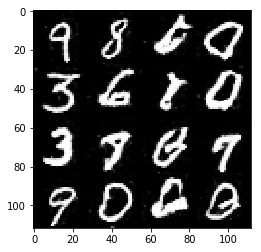

Epoch: 2/2    Batch:    D_Loss: 2.2433    G_Loss: 0.2746
Epoch: 2/2    Batch:    D_Loss: 1.8122    G_Loss: 0.4462
Epoch: 2/2    Batch:    D_Loss: 1.3934    G_Loss: 1.3446
Epoch: 2/2    Batch:    D_Loss: 2.0038    G_Loss: 0.3413
Epoch: 2/2    Batch:    D_Loss: 1.3005    G_Loss: 0.8256
Epoch: 2/2    Batch:    D_Loss: 1.3067    G_Loss: 0.6637
Epoch: 2/2    Batch:    D_Loss: 1.5153    G_Loss: 0.7638
Epoch: 2/2    Batch:    D_Loss: 1.7493    G_Loss: 0.7304
Epoch: 2/2    Batch:    D_Loss: 1.5604    G_Loss: 0.7562
Epoch: 2/2    Batch:    D_Loss: 2.0666    G_Loss: 0.3121


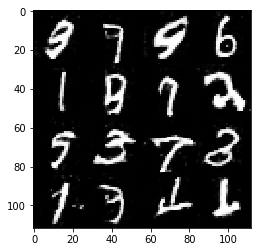

Epoch: 2/2    Batch:    D_Loss: 2.2612    G_Loss: 0.2385
Epoch: 2/2    Batch:    D_Loss: 2.0500    G_Loss: 0.3369
Epoch: 2/2    Batch:    D_Loss: 1.7851    G_Loss: 0.3888
Epoch: 2/2    Batch:    D_Loss: 1.8736    G_Loss: 0.3873
Epoch: 2/2    Batch:    D_Loss: 1.3396    G_Loss: 0.6428
Epoch: 2/2    Batch:    D_Loss: 2.0520    G_Loss: 0.3162
Epoch: 2/2    Batch:    D_Loss: 1.6246    G_Loss: 0.5052
Epoch: 2/2    Batch:    D_Loss: 1.5155    G_Loss: 0.6804
Epoch: 2/2    Batch:    D_Loss: 1.5531    G_Loss: 0.6934
Epoch: 2/2    Batch:    D_Loss: 1.3043    G_Loss: 0.6059


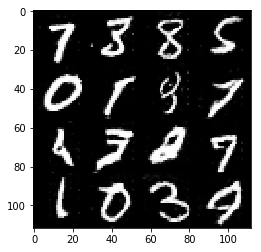

Epoch: 2/2    Batch:    D_Loss: 1.7031    G_Loss: 0.4609
Epoch: 2/2    Batch:    D_Loss: 1.7082    G_Loss: 0.5394
Epoch: 2/2    Batch:    D_Loss: 1.4782    G_Loss: 1.1002
Epoch: 2/2    Batch:    D_Loss: 1.7812    G_Loss: 0.3974
Epoch: 2/2    Batch:    D_Loss: 2.0580    G_Loss: 0.3079
Epoch: 2/2    Batch:    D_Loss: 1.3911    G_Loss: 0.5766
Epoch: 2/2    Batch:    D_Loss: 1.7714    G_Loss: 0.6018
Epoch: 2/2    Batch:    D_Loss: 1.6102    G_Loss: 0.5075
Epoch: 2/2    Batch:    D_Loss: 1.6912    G_Loss: 0.3357
Epoch: 2/2    Batch:    D_Loss: 1.6294    G_Loss: 0.5448


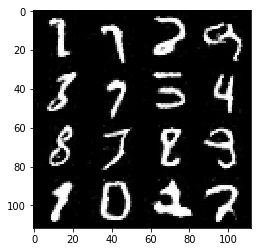

Epoch: 2/2    Batch:    D_Loss: 1.4135    G_Loss: 0.8208
Epoch: 2/2    Batch:    D_Loss: 1.9584    G_Loss: 0.2845
Epoch: 2/2    Batch:    D_Loss: 1.9776    G_Loss: 0.3118
Epoch: 2/2    Batch:    D_Loss: 1.6891    G_Loss: 0.9653
Epoch: 2/2    Batch:    D_Loss: 1.1959    G_Loss: 1.0755
Epoch: 2/2    Batch:    D_Loss: 1.9279    G_Loss: 0.3669
Epoch: 2/2    Batch:    D_Loss: 1.6627    G_Loss: 0.6889
Epoch: 2/2    Batch:    D_Loss: 1.7013    G_Loss: 1.3655
Epoch: 2/2    Batch:    D_Loss: 1.8727    G_Loss: 0.3541
Epoch: 2/2    Batch:    D_Loss: 1.4707    G_Loss: 0.5232


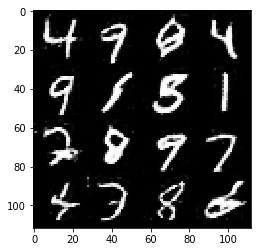

Epoch: 2/2    Batch:    D_Loss: 1.6613    G_Loss: 0.6796
Epoch: 2/2    Batch:    D_Loss: 1.3710    G_Loss: 0.7661
Epoch: 2/2    Batch:    D_Loss: 1.7139    G_Loss: 0.7152
Epoch: 2/2    Batch:    D_Loss: 2.5524    G_Loss: 0.1922
Epoch: 2/2    Batch:    D_Loss: 1.4679    G_Loss: 0.6964
Epoch: 2/2    Batch:    D_Loss: 1.5667    G_Loss: 0.5444
Epoch: 2/2    Batch:    D_Loss: 1.9890    G_Loss: 0.2887
Epoch: 2/2    Batch:    D_Loss: 2.0912    G_Loss: 0.2329
Epoch: 2/2    Batch:    D_Loss: 1.5970    G_Loss: 1.0939
Epoch: 2/2    Batch:    D_Loss: 1.6162    G_Loss: 0.3984


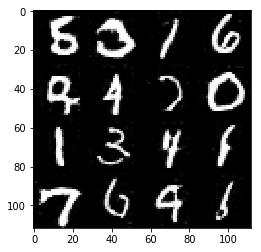

Epoch: 2/2    Batch:    D_Loss: 1.7001    G_Loss: 0.4722
Epoch: 2/2    Batch:    D_Loss: 2.0594    G_Loss: 0.3029
Epoch: 2/2    Batch:    D_Loss: 1.5646    G_Loss: 0.7400
Epoch: 2/2    Batch:    D_Loss: 1.6339    G_Loss: 0.6448
Epoch: 2/2    Batch:    D_Loss: 1.4367    G_Loss: 0.6963


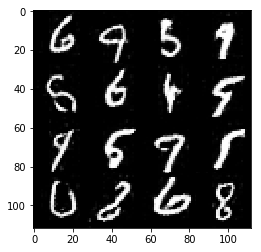

In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1   Batch:    D_Loss: 2.6781    G_Loss: 0.1196
Epoch: 1/1   Batch:    D_Loss: 2.2712    G_Loss: 1.3597
Epoch: 1/1   Batch:    D_Loss: 1.7458    G_Loss: 0.3837
Epoch: 1/1   Batch:    D_Loss: 1.8674    G_Loss: 0.3049
Epoch: 1/1   Batch:    D_Loss: 1.5318    G_Loss: 0.9810
Epoch: 1/1   Batch:    D_Loss: 1.4331    G_Loss: 0.7385
Epoch: 1/1   Batch:    D_Loss: 1.4838    G_Loss: 0.7787
Epoch: 1/1   Batch:    D_Loss: 0.9394    G_Loss: 0.8857
Epoch: 1/1   Batch:    D_Loss: 1.2015    G_Loss: 0.7228
Epoch: 1/1   Batch:    D_Loss: 1.4427    G_Loss: 0.6079


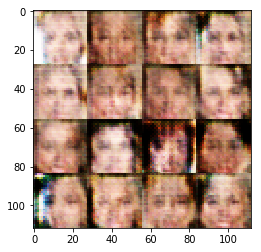

Epoch: 1/1   Batch:    D_Loss: 1.3806    G_Loss: 0.7815
Epoch: 1/1   Batch:    D_Loss: 1.4014    G_Loss: 0.7150
Epoch: 1/1   Batch:    D_Loss: 1.4124    G_Loss: 0.8302
Epoch: 1/1   Batch:    D_Loss: 1.7644    G_Loss: 0.4331
Epoch: 1/1   Batch:    D_Loss: 1.4291    G_Loss: 0.8210
Epoch: 1/1   Batch:    D_Loss: 1.7150    G_Loss: 0.4276
Epoch: 1/1   Batch:    D_Loss: 1.5786    G_Loss: 0.4907
Epoch: 1/1   Batch:    D_Loss: 1.4100    G_Loss: 0.7835
Epoch: 1/1   Batch:    D_Loss: 1.3762    G_Loss: 0.8748
Epoch: 1/1   Batch:    D_Loss: 1.4831    G_Loss: 0.5381


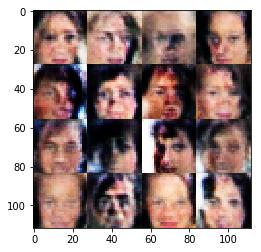

Epoch: 1/1   Batch:    D_Loss: 1.4368    G_Loss: 0.7559
Epoch: 1/1   Batch:    D_Loss: 1.3754    G_Loss: 0.7588
Epoch: 1/1   Batch:    D_Loss: 1.3656    G_Loss: 0.8339
Epoch: 1/1   Batch:    D_Loss: 1.3882    G_Loss: 0.8029
Epoch: 1/1   Batch:    D_Loss: 1.4228    G_Loss: 0.7230
Epoch: 1/1   Batch:    D_Loss: 1.3469    G_Loss: 0.7825
Epoch: 1/1   Batch:    D_Loss: 1.4042    G_Loss: 0.5784
Epoch: 1/1   Batch:    D_Loss: 1.3331    G_Loss: 0.8925
Epoch: 1/1   Batch:    D_Loss: 1.4194    G_Loss: 0.7751
Epoch: 1/1   Batch:    D_Loss: 1.4114    G_Loss: 0.7062


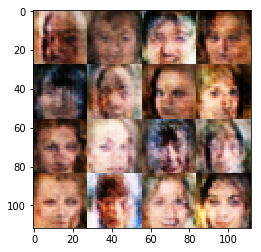

Epoch: 1/1   Batch:    D_Loss: 1.4138    G_Loss: 0.7464
Epoch: 1/1   Batch:    D_Loss: 1.4206    G_Loss: 0.6865
Epoch: 1/1   Batch:    D_Loss: 1.4282    G_Loss: 0.5876
Epoch: 1/1   Batch:    D_Loss: 1.5042    G_Loss: 0.6740
Epoch: 1/1   Batch:    D_Loss: 1.3742    G_Loss: 0.7879
Epoch: 1/1   Batch:    D_Loss: 1.4135    G_Loss: 0.9301
Epoch: 1/1   Batch:    D_Loss: 1.4798    G_Loss: 0.6711
Epoch: 1/1   Batch:    D_Loss: 1.4344    G_Loss: 0.7367
Epoch: 1/1   Batch:    D_Loss: 1.6686    G_Loss: 0.4260
Epoch: 1/1   Batch:    D_Loss: 1.4518    G_Loss: 0.5593


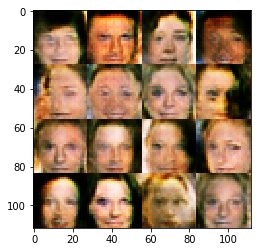

Epoch: 1/1   Batch:    D_Loss: 1.3783    G_Loss: 0.5689
Epoch: 1/1   Batch:    D_Loss: 1.4986    G_Loss: 0.6488
Epoch: 1/1   Batch:    D_Loss: 1.5501    G_Loss: 0.5977
Epoch: 1/1   Batch:    D_Loss: 1.3875    G_Loss: 0.7321
Epoch: 1/1   Batch:    D_Loss: 1.7874    G_Loss: 0.4102
Epoch: 1/1   Batch:    D_Loss: 1.4296    G_Loss: 0.7362
Epoch: 1/1   Batch:    D_Loss: 1.4613    G_Loss: 0.5743
Epoch: 1/1   Batch:    D_Loss: 1.4221    G_Loss: 0.7907
Epoch: 1/1   Batch:    D_Loss: 1.3685    G_Loss: 0.7763
Epoch: 1/1   Batch:    D_Loss: 1.4237    G_Loss: 0.7551


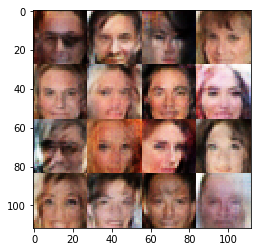

Epoch: 1/1   Batch:    D_Loss: 1.2203    G_Loss: 0.7877
Epoch: 1/1   Batch:    D_Loss: 1.4566    G_Loss: 0.4659
Epoch: 1/1   Batch:    D_Loss: 1.2939    G_Loss: 0.6713
Epoch: 1/1   Batch:    D_Loss: 1.4684    G_Loss: 0.5759
Epoch: 1/1   Batch:    D_Loss: 1.4111    G_Loss: 0.5728
Epoch: 1/1   Batch:    D_Loss: 1.4776    G_Loss: 0.6499
Epoch: 1/1   Batch:    D_Loss: 1.5102    G_Loss: 0.5139
Epoch: 1/1   Batch:    D_Loss: 1.4031    G_Loss: 0.7355
Epoch: 1/1   Batch:    D_Loss: 1.3969    G_Loss: 0.8473
Epoch: 1/1   Batch:    D_Loss: 1.7491    G_Loss: 0.4047


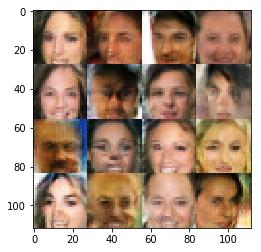

Epoch: 1/1   Batch:    D_Loss: 1.5764    G_Loss: 0.6160
Epoch: 1/1   Batch:    D_Loss: 1.4505    G_Loss: 0.6003
Epoch: 1/1   Batch:    D_Loss: 1.4067    G_Loss: 0.6948


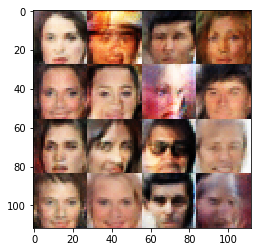

In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.